In [1]:
%cd /home/yokoyama/research
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

sys.path.append(".")
from modules.utils.video import Capture, Writer
from modules.pose import PoseDataHandler

/raid6/home/yokoyama/research


In [2]:
from submodules.i3d.pytorch_i3d import InceptionI3d
from torchvision.ops import roi_align

In [3]:
video_num = 1
cap = Capture(f"/raid6/home/yokoyama/datasets/dataset01/train/{video_num:02d}.mp4")
pose_data = PoseDataHandler.load(f"data/dataset01/train/{video_num:02d}", ["bbox"])

In [4]:
def calc_opticalflow(frames):
    prev_frame = frames[0]
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    h, w = prev_frame.shape[:2]
    flows = [np.zeros((h, w, 2), dtype=np.float32)]
    for frame in tqdm(frames[1:], leave=False):
        next_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

    return np.array(flows)


def load_rgb_frames(cap, start_frame_nums, length, resize_ratio):
    batches_frame = []
    batches_flow = []
    for start in tqdm(start_frame_nums):
        frames_raw = []
        frames = []
        cap.set_pos_frame_count(start)
        for _ in tqdm(range(length), leave=False):
            img = cap.read()[1]
            img = cv2.resize(img, None, fx=resize_ratio, fy=resize_ratio)
            # w, h, c = img.shape
            # if w < 226 or h < 226:
            #     d = 226. - min(w, h)
            #     sc = 1 + d / min(w, h)
            #     img = cv2.resize(img, None, fx=sc, fy=sc)
            frames_raw.append(img.copy())
            img = (img / 255.) * 2 - 1
            frames.append(img)

        batches_frame.append(frames)

        flows = calc_opticalflow(frames_raw)
        batches_flow.append(flows)
    return np.array(batches_frame, dtype=np.float32), np.array(batches_flow, dtype=np.float32)


batch_num = 64
frame_length = 30
# start_frame_nums = sorted(np.random.choice(cap.frame_count, batch_num, replace=True) + 1)
start_frame_nums = sorted(np.random.choice(100, batch_num, replace=True) + 1)
frames, flows = load_rgb_frames(cap, start_frame_nums, frame_length, 0.25)
print(start_frame_nums)

100%|██████████| 64/64 [00:42<00:00,  1.50it/s]


[1, 3, 5, 9, 11, 12, 13, 15, 15, 16, 17, 18, 20, 20, 21, 23, 27, 34, 34, 35, 35, 37, 37, 38, 38, 40, 40, 41, 41, 46, 47, 47, 48, 51, 51, 56, 59, 60, 61, 62, 62, 64, 66, 67, 68, 75, 76, 77, 79, 79, 81, 83, 84, 84, 84, 87, 87, 88, 89, 92, 93, 95, 96, 98]


In [5]:
in_channels = 2

if in_channels == 3:
    tensor = torch.Tensor(frames)
    model_path = "submodules/i3d/models/rgb_imagenet.pt"
    # model_path = "submodules/i3d/models/rgb_charades.pt"
elif in_channels == 2:
    tensor = torch.Tensor(flows)
    model_path = "submodules/i3d/models/flow_imagenet.pt"
    # model_path = "submodules/i3d/models/flow_charades.pt"
tensor = torch.permute(tensor, (0, 4, 1, 2, 3))
tensor.shape

torch.Size([64, 2, 30, 235, 320])

In [6]:
i3d = InceptionI3d(in_channels=in_channels)
# i3d.cuda(1)
# i3d.replace_logits(157)
i3d.load_state_dict(torch.load(model_path))

# i3d = InceptionI3d(in_channels=in_channels, final_endpoint="Mixed_3b")
# i3d.build()
# i3d.cuda(1)
print("done")

done


In [7]:
# feature = i3d.extract_features(tensor)
x = tensor[:1]
for end_point in i3d.VALID_ENDPOINTS:
    if end_point in i3d.end_points:
        x = i3d._modules[end_point](x)
    if end_point == "Mixed_3b":
        break
feature = x.cpu()
feature.shape

torch.Size([1, 256, 15, 30, 40])

torch.Size([2, 256, 15, 118, 160]) 3b  
torch.Size([2, 480, 15, 118, 160]) 3c  
torch.Size([1, 480, 8, 59, 80]) 4a  
torch.Size([1, 512, 8, 59, 80]) 4b  
torch.Size([1, 832, 8, 59, 80]) 4f

In [8]:
h, w = frames.shape[2:4]
fy, fx = feature.shape[3:5]
fx / w

0.125

In [19]:
bboxs_all = []
for start_frame_num in start_frame_nums:
    pose_data_frame = [
        data for data in pose_data
        if data["frame"] == start_frame_num
    ]

    bboxs = [np.array(data["bbox"]).reshape(2, 2) for data in pose_data_frame]

    bboxs = torch.Tensor(np.array(bboxs))
    bboxs /= torch.Tensor((w, h))
    bboxs *= torch.Tensor((fx, fy))

    bboxs_all.append(bboxs.reshape(-1, 4))

# bboxs_all = torch.empty((0, 5))
# for i, start_frame_num in enumerate(start_frame_nums):
#     pose_data_batch = [
#         data for data in pose_data
#         if data["frame"] == start_frame_num + frame_length - 1
#     ]

#     bboxs = [np.array(data["bbox"]).reshape(2, 2) for data in pose_data_batch]
#     bboxs = torch.Tensor(np.array(bboxs))
#     bboxs /= torch.Tensor((w, h))
#     bboxs *= torch.Tensor((fx, fy))
#     bboxs = bboxs.reshape(-1, 4)
#     bboxs = torch.cat([torch.full((len(pose_data_batch), 1), i), bboxs], 1)

#     bboxs_all = torch.cat([bboxs_all, bboxs], axis=0)
# bboxs_all = torch.Tensor(bboxs_all)

output_size = 3
feature_aligned = roi_align(feature, bboxs_all, output_size, spatial_scale=fx / w, aligned=False)
feature_aligned = feature_aligned.detach().numpy()

feature_aligned.shape

(232, 256, 3, 3)

In [20]:
feature_aligned[0, 0]

array([[1.622098  , 0.40036553, 0.40775394],
       [0.40006438, 0.3081165 , 0.8980869 ],
       [0.25440624, 0.23870555, 0.20666772]], dtype=float32)

In [21]:
np.any(np.isinf(feature_aligned))

False

In [22]:
np.any(np.isnan(feature_aligned))

False

In [23]:
pids_all_batch = [
    [
        data["id"] for data in pose_data
        if data["frame"] == start_frame_num
    ]
    for start_frame_num in start_frame_nums
]

In [24]:
features_aligned_all = feature_aligned.reshape(-1, 256 * output_size**2)
# um = umap.UMAP(n_neighbors=6, random_state=64)
# um.fit(features_aligned_all)
pca = PCA(n_components=2)
pca.fit(features_aligned_all)

embedding_dict = {}
tail_idx = 0
for pid_batch, start_frame_num in zip(pids_all_batch, start_frame_nums):
    data_num = len(pid_batch)
    # pca = PCA(n_components=2)
    # pca.fit(feature_aligned[tail_idx: tail_idx + data_num].reshape(-1, 256 * 2 * 2))
    for i, pid in enumerate(pid_batch):
        features = feature_aligned[i + tail_idx]
        # embedding = um.transform(features.reshape(-1, 256 * 2 * 2))
        embedding = pca.transform(features.reshape(-1, 256 * output_size**2))

        if pid not in embedding_dict:
            embedding_dict[pid] = np.empty((0, 3))
        embedding = np.append(embedding, start_frame_num)
        embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

    tail_idx += data_num

In [25]:
print(start_frame_nums)

[1, 3, 5, 9, 11, 12, 13, 15, 15, 16, 17, 18, 20, 20, 21, 23, 27, 34, 34, 35, 35, 37, 37, 38, 38, 40, 40, 41, 41, 46, 47, 47, 48, 51, 51, 56, 59, 60, 61, 62, 62, 64, 66, 67, 68, 75, 76, 77, 79, 79, 81, 83, 84, 84, 84, 87, 87, 88, 89, 92, 93, 95, 96, 98]


/tmp/ipykernel_3897733/928680282.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


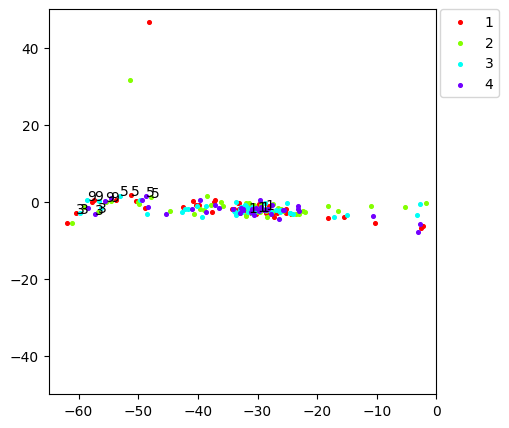

In [28]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid, c=cm.hsv(i / len(embedding_dict))
    )
    for j in range(len(embedding)):
        if embedding[j, 2] in start_frame_nums[:4]:
            plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
plt.xlim((-65, 0))
plt.ylim((-50, 50))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()